In [1]:
## math, plotting
import matplotlib.pyplot as plt
import seaborn as sb

import numpy as np
import pandas as pd
import scipy.stats

## machine learning
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


import pickle

import sys
from os import listdir
sys.path.append('../../Beltway_Project/')
sys.path.append('../../RatterdamOpen_Project/')
sys.path.append('../DATA/')
sys.path.append('../../../ratterdam/')


import RateMapClass_William_20190308 as RateMapClass
import ratterdam_RepetitionCoreFx as CoreFx
import confounds as direction
import newAlleyBounds as bounds2

In [2]:
def train_test_scorer(x,y, inst_fr):
    target1 = (x-np.mean(x))/np.std(x)
    target2 = (y-np.mean(y))/np.std(y)

    train_size = 8000
    test_size = 1000
    buffer = int((dt-train_size-test_size)/2)
    for i in range(0, int(len(inst_fr)/dt)):
        if i == 0:
            X_train = inst_fr[i*dt : i*dt + train_size,:]
            y_train1 = target1[i*dt : i*dt + train_size]
            y_train2 = target2[i*dt : i*dt + train_size]
            X_test = inst_fr[(i)*dt + train_size + buffer: (i)*dt + train_size + buffer+test_size,:]
            y_test1 = target1[(i)*dt + train_size + buffer: (i)*dt + train_size + buffer+test_size]
            y_test2 = target2[(i)*dt + train_size + buffer: (i)*dt + train_size + buffer+test_size]
        else:
            X_train  = np.vstack((X_train, inst_fr[i*dt + buffer: i*dt + train_size+ buffer]))
            ##print('training', i*dt + buffer,i*dt + train_size+ buffer)
            X_test = np.vstack((X_test, inst_fr[(i)*dt + train_size + 2*buffer: (i)*dt + train_size + 2*buffer+test_size,:]))
            ##print('testing',(i)*dt + train_size + 2*buffer,((i)*dt + train_size + 2*buffer+test_size))
            y_train1 = np.append(y_train1, target1[i*dt+ buffer: i*dt + train_size+ buffer])
            y_test1 = np.append(y_test1, target1[(i)*dt + train_size + 2*buffer: (i)*dt + train_size + 2*buffer+test_size])

            y_train2 = np.append(y_train2, target2[i*dt+ buffer: i*dt + train_size+ buffer])
            y_test2 = np.append(y_test2, target2[(i)*dt + train_size + 2*buffer: (i)*dt + train_size + 2*buffer+test_size])

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)        

    model = LinearRegression()
    model.fit(X_train, y_train1)

    model2 = LinearRegression()
    model2.fit(X_train, y_train2)
    
    
    train_score = (model.score(X_train, y_train1) + model2.score(X_train, y_train2))/2
    test_score = (model.score(X_test, y_test1) + model2.score(X_test, y_test2))/2
    ##print('model score', model.score(X_train, y_train1))
    ##ypred = model.predict(X_train)
    ##print('r2 function', r2_score(y_train1, ypred))
    return(np.array([train_score, test_score]))



In [3]:
## Reading in file with all data
file = open('../DATA/20220405-124315_superPopulationRepetition.pickle','rb')
alldat = pickle.load(file)

store_dir = '../DATA/FILES/'
num_rep = 100
num_down_samp = 10
dt = 10000
all_num_repeat= []
all_num = []
all_rats = list(alldat.keys())
all_rat_day = []
all_scores = []
for rat in all_rats:  
    all_days = list(alldat[rat].keys())
    for day in all_days:
        print(rat, day)
        day_scores = np.zeros((num_rep,2))
        for rep in range(0,num_rep):
            all_rat_day.append(rat+ '_' + day)
            inst_fr = np.load(store_dir + rat + '_' + day + '_inst_fr.npy')
            x_order = np.load(store_dir + rat + '_' + day + '_x_within.npy')
            y_order = np.load(store_dir + rat + '_' + day + '_y_within.npy')
            
            shuff_start = np.random.choice(len(inst_fr),1)[0]
            shuff_inst_fr = np.vstack((inst_fr[shuff_start:,:], inst_fr[0:shuff_start,:]))
            inst_fr = shuff_inst_fr
            x = np.concatenate((x_order[shuff_start:], x_order[0:shuff_start]))
            y = np.concatenate((y_order[shuff_start:], y_order[0:shuff_start]))
            
            repeating_cells = []
            all_cells = alldat[rat][day]['units'].keys()
            for each_cell in all_cells:
                data = alldat[rat][day]['units'][each_cell]
                if data.repeating == True:
                    repeating_cells.append(True)
                else:
                    repeating_cells.append(False)
                    
            repeating_cells = np.array(repeating_cells)
            repeat_len = np.sum(repeating_cells)
            non_repeat_len = len(repeating_cells)- repeat_len
            
            if repeat_len<non_repeat_len:
                inst_fr_rep = inst_fr[:,repeating_cells]
                if len(inst_fr_rep[0])>0:
                    curr_score = np.array(train_test_scorer(x,y, inst_fr_rep))
                    
                    scores_non_rep = np.zeros((num_down_samp,2))
                    for down_sampling in range(0, num_down_samp):
                        cells_chosen = np.random.choice(np.where(repeating_cells== False)[0],repeat_len)
                        inst_fr_non = inst_fr[:,cells_chosen]
                        scores_non_rep[down_sampling,:] = train_test_scorer(x,y, inst_fr_non)

                    day_scores[rep,:] = curr_score-np.mean(scores_non_rep, axis = 0)
                    ##print(curr_score,np.mean(scores_non_rep, axis = 0))
            

            
            
            else:
                cells_chosen = np.random.choice(np.where(repeating_cells== True)[0],non_repeat_len)
                inst_fr_rep = inst_fr[:,cells_chosen]
                curr_score = np.array(train_test_scorer(x,y, inst_fr_rep))
                inst_fr_non =inst_fr[:,repeating_cells==False]
                day_scores[rep,:] = curr_score-np.array(train_test_scorer(x,y, inst_fr_non))
                
        all_scores.append(day_scores)

R765 RFD5
R765 DFD4
R781 D3
R781 D4
R808 D6
R808 D7
R859 D1
R859 D2
R886 D1
R886 D2


doing


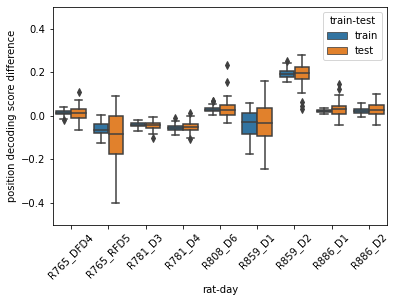

In [4]:
## Figure plotting

all_scores = np.array(all_scores)
for i in range(0, len(all_scores)):
    if np.sum(all_scores[i,:,0] == 0.0) == len(all_scores[i]):
        print('doing')
        all_scores_edit = np.delete(all_scores[:,:,:], i,0)
        
all_scores = all_scores_edit

all_rat_day = np.array(all_rat_day)
all_rat_day = all_rat_day[all_rat_day!='R808_D7']


all_scores = np.array(all_scores)
score_df = pd.DataFrame(all_scores[:,:,0].flatten(), columns = ['score'])
score_df['rat-day'] = np.array(all_rat_day)
score_df['train-test'] = ['train']*len(all_rat_day)

score_df2= pd.DataFrame(all_scores[:,:,1].flatten(), columns = ['score'])
score_df2['rat-day'] = np.array(all_rat_day)
score_df2['train-test'] = ['test']*len(all_rat_day)

score_df_all = pd.concat([score_df, score_df2])

fig, ax = plt.subplots()
sb.boxplot(x = score_df_all['rat-day'], y = score_df_all['score'], hue = score_df_all['train-test'])
ax.set_xticklabels(np.unique(all_rat_day),rotation = 45)
ax.set_ylabel('position decoding score difference')

## axis limited
ax.set_ylim(-0.5, 0.5)
plt.show()

In [5]:
## Statistics
## Test if mean is equal to 0
all_means = np.mean(all_scores[:,:,1], axis = 1)
scipy.stats.ttest_1samp(all_means,0)

## pvalue>0.05
## we cannot reject the null that the scores are different


Ttest_1sampResult(statistic=0.4122221426454688, pvalue=0.6910013167864302)

In [6]:
## Statistics
## Test if mean is equal to 0
all_pval = []
print('rat-day', 'mean diff scores', 'ttest pvalue- diff from 0')
for i in range(len(all_scores)):
    if np.sum(all_scores[i,:,1]==0.0) != len(all_scores[i,:,1]):
        curr_pval = scipy.stats.ttest_1samp(all_scores[i,:,1],0).pvalue
        all_pval.append(curr_pval)
        print(np.unique(all_rat_day)[i], f'{np.mean(all_scores[i,:,1]):.3}', f'{curr_pval:.3}')



rat-day mean diff scores ttest pvalue- diff from 0
R765_DFD4 0.0128 4.1e-05
R765_RFD5 -0.0911 1.01e-12
R781_D3 -0.0443 2.36e-41
R781_D4 -0.0516 5.77e-41
R808_D6 0.0623 0.00279
R859_D1 -0.0374 6.95e-05
R859_D2 0.195 5.97e-64
R886_D1 0.0304 3.75e-15
R886_D2 0.0283 7.05e-14
